Dataset successfully Imported of Shape : (76014, 15)
After Removing Irrelevant Columns : (76014, 8)
After Removing Inconsistent Teams : (53811, 8)
After Removing Overs : (40108, 8)


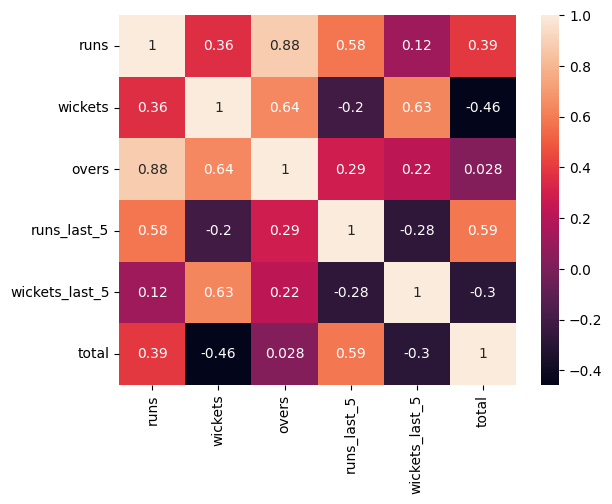

Training Set : (32086, 7)
Testing Set : (8022, 7)
Train Score : 99.04%
Test Score : 93.49%
Predicted Score : 147 || Actual Score : 147


In [1]:
# Import all necessary libraries at the beginning
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error as mae, mean_squared_error as mse
import pickle

# Set random seed for reproducibility
np.random.seed(42)

# Load dataset
ipl_df = pd.read_csv('ipl_data.csv')
print(f"Dataset successfully Imported of Shape : {ipl_df.shape}")

# Data Cleaning
irrelevant = ['mid', 'date', 'venue', 'batsman', 'bowler', 'striker', 'non-striker']
ipl_df = ipl_df.drop(irrelevant, axis=1)
print(f'After Removing Irrelevant Columns : {ipl_df.shape}')

# Keep only consistent teams
const_teams = ['Kolkata Knight Riders', 'Chennai Super Kings', 'Rajasthan Royals',
               'Mumbai Indians', 'Kings XI Punjab', 'Royal Challengers Bangalore',
               'Delhi Daredevils', 'Sunrisers Hyderabad']
ipl_df = ipl_df[(ipl_df['bat_team'].isin(const_teams)) & (ipl_df['bowl_team'].isin(const_teams))]
print(f'After Removing Inconsistent Teams : {ipl_df.shape}')

# Remove first 5 overs
ipl_df = ipl_df[ipl_df['overs'] >= 5.0]
print(f'After Removing Overs : {ipl_df.shape}')

# Correlation heatmap
sns.heatmap(data=ipl_df.corr(numeric_only=True), annot=True)
plt.show()

# Prepare features and labels
features = ipl_df.drop(['total'], axis=1)
labels = ipl_df['total']

# Train-test split
train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, test_size=0.20, random_state=42
)
print(f"Training Set : {train_features.shape}\nTesting Set : {test_features.shape}")

# Define preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), ['bat_team', 'bowl_team'])
    ],
    remainder='passthrough'
)

# Create and train pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])
pipeline.fit(train_features, train_labels)

# Evaluate model
train_score = pipeline.score(train_features, train_labels) * 100
test_score = pipeline.score(test_features, test_labels) * 100
print(f'Train Score : {train_score:.2f}%\nTest Score : {test_score:.2f}%')

# Save model and preprocessor
with open('ml_model.pkl', 'wb') as f:
    pickle.dump(pipeline, f)
with open('preprocessor.pkl', 'wb') as f:
    pickle.dump(preprocessor, f)

# Prediction function
def score_predict(batting_team, bowling_team, runs, wickets, overs, runs_last_5, wickets_last_5, model=pipeline):
    valid_teams = ['Chennai Super Kings', 'Delhi Daredevils', 'Kings XI Punjab', 'Kolkata Knight Riders',
                   'Mumbai Indians', 'Rajasthan Royals', 'Royal Challengers Bangalore', 'Sunrisers Hyderabad']
    if batting_team not in valid_teams or bowling_team not in valid_teams:
        raise ValueError("Invalid team name")
    if any(x < 0 for x in [runs, wickets, overs, runs_last_5, wickets_last_5]):
        raise ValueError("Input values cannot be negative")
    if overs > 20 or wickets > 10:
        raise ValueError("Invalid overs or wickets")

    input_data = pd.DataFrame({
        'bat_team': [batting_team],
        'bowl_team': [bowling_team],
        'runs': [runs],
        'wickets': [wickets],
        'overs': [overs],
        'runs_last_5': [runs_last_5],
        'wickets_last_5': [wickets_last_5]
    })
    pred = model.predict(input_data)
    return int(round(pred[0]))

# Example prediction
batting_team = 'Delhi Daredevils'
bowling_team = 'Chennai Super Kings'
score = score_predict(batting_team, bowling_team, overs=10.2, runs=68, wickets=3, runs_last_5=29, wickets_last_5=1)
print(f'Predicted Score : {score} || Actual Score : 147')

In [4]:
batting_team = 'Delhi Daredevils'
bowling_team = 'Chennai Super Kings'
score = score_predict(batting_team, bowling_team, overs=18.0, runs=187, wickets=3, runs_last_5=64, wickets_last_5=0)
print(f'Predicted Score : {score} || Actual Score : 147')

Predicted Score : 209 || Actual Score : 147
